#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* (선택) 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* (선택) 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/Aivle/DL/AI_미니프로젝트 1차_실습자료/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
  - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [5]:
# 주어진 데이터 셋을 불러오세요.(3개)
train_data = pd.read_csv(path + 'data01_train.csv')
test_data = pd.read_csv(path + 'data01_test.csv')


In [6]:
#불필요한 칼럼을 삭제하세요.
train_data.drop('subject', axis=1, inplace=True)
test_data.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [7]:
#전체 데이터의 행,열 개수 확인

In [8]:
#전체 데이터의 상위 5개 행 확인

In [9]:
#전체 데이터의 수치형 변수 분포 확인

In [10]:
#전체 데이터의 모든 변수 확인

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [11]:
#Lable 추가(1단계 모델:정적(0), 동적(1) 행동 분류 모델 생성 )
train_data['is_dynamic'] = train_data['Activity'].apply(lambda x : 0 if x in ['STANDING', 'SITTING', 'LAYING'] else 1)
test_data['is_dynamic'] = test_data['Activity'].apply(lambda x : 0 if x in ['STANDING', 'SITTING', 'LAYING'] else 1)

### (2) x, y 분리

In [12]:
#x,y 분리하기
x_train = train_data.drop(['Activity', 'is_dynamic'], axis=1)
y_train = train_data['is_dynamic']


### (4) 데이터 분할
* train, val 분할

In [13]:
#데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [14]:
#스케일링 방식을 선택해서 스케일링을 진행합니다.
scaler = MinMaxScaler()
x_train_minmax = scaler.fit_transform(x_train)
x_val_minmax = scaler.transform(x_val)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.(기본 모델링 참고)

In [15]:
from keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',          # 개선 여부를 체크할 지표 (검증 손실)
    patience=5,                  # 5번의 epoch 동안 개선이 없으면 학습 중단
    restore_best_weights=True   # 가장 좋은 성능을 보였을 때의 모델 가중치 복원
)

#### 1) 모델1

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
# 모델 설계
#RandomForestClassifier로 모델링 진행
model_sd_rfc = RandomForestClassifier()
model_sd_rfc.fit(x_train, y_train)
model_sd_rfc.score(x_val, y_val)

1.0

In [18]:
# 컴파일 및 학습


In [19]:
# 학습곡선

In [20]:
# 예측 및 평가

#### 2) 모델2

In [21]:
# 모델 설계
model_sd_hid=Sequential()
model_sd_hid.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
model_sd_hid.add(Dense(64, activation='relu'))
model_sd_hid.add(Dense(32, activation='relu'))
model_sd_hid.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# 컴파일 및 학습
model_sd_hid.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history = model_sd_hid.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9824 - loss: 0.0664 - val_accuracy: 1.0000 - val_loss: 7.2399e-05
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9976 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 5.3170e-05
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9995 - loss: 6.3362e-04 - val_accuracy: 1.0000 - val_loss: 3.1795e-05
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 6.2039e-05 - val_accuracy: 1.0000 - val_loss: 9.1847e-06
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.5821e-05 - val_accuracy: 1.0000 - val_loss: 7.2810e-06
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 8.9392e-06 - val_accuracy: 1.0000 - val_loss: 5.8768e-06
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 5.5627e-06 - val_accuracy: 1.0000 - val_loss: 5.3294e-06
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - ac

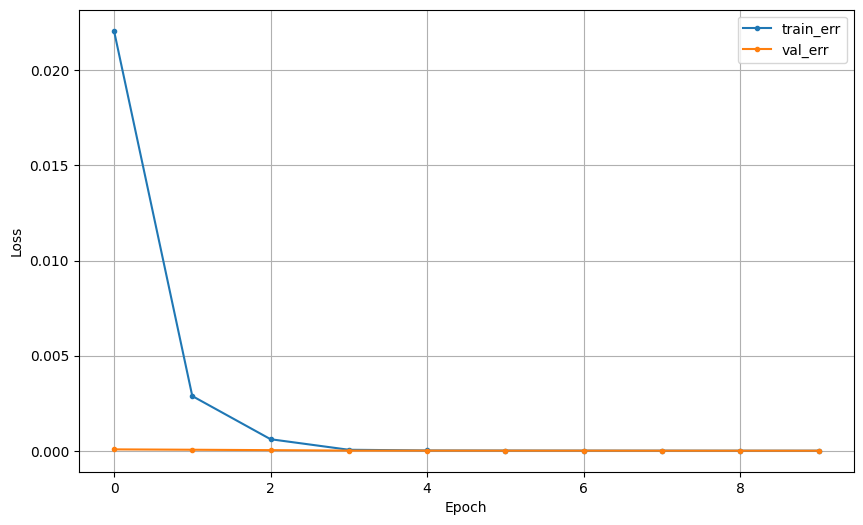

In [23]:
# 학습곡선
dl_history_plot(history.history)

In [24]:
x_test, y_test = test_data.drop(['Activity', 'is_dynamic'], axis=1), test_data['Activity']
x_test

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,0.255432,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.166341,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.468354,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,0.337635,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,-0.594792,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,0.278725,-0.015262,-0.106398,-0.993625,-0.982845,-0.974745,-0.993963,-0.981100,-0.974596,-0.939303,...,0.166124,-0.586580,-0.874066,-0.054788,0.712975,0.300318,-0.319188,-0.857336,0.120184,0.119276
1467,0.275803,-0.019257,-0.109078,-0.998614,-0.991621,-0.987403,-0.998813,-0.991503,-0.986802,-0.945442,...,0.425059,-0.451941,-0.721050,0.076333,-0.021599,-0.277268,0.754011,-0.764185,0.212111,0.138595
1468,0.240402,0.006361,-0.121377,-0.045805,0.189930,0.332664,-0.114706,0.157771,0.195271,0.210139,...,0.187655,-0.213340,-0.615554,0.330378,-0.667635,0.806563,-0.850113,-0.639564,0.185363,0.260201
1469,0.135873,-0.020675,-0.116644,-0.960526,-0.955134,-0.985818,-0.963115,-0.971338,-0.988261,-0.946289,...,-0.200412,0.072602,-0.422383,-0.048474,0.236761,-0.186581,0.396648,0.790877,-0.474618,-0.505953


In [25]:
# 예측 및 평가
y_pred = model_sd_hid.predict(x_val)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_val, y_pred))
print(y_pred[0][0])

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       657
           1       1.00      1.00      1.00       520

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

0


### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

In [26]:
train_data

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS,1
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS,1


* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [27]:
# (tip) 정적 행동(0)인 데이터 추출
x_train_static = train_data[train_data['is_dynamic'] == 0].drop(['Activity', 'is_dynamic'], axis=1)
y_train_static = train_data[train_data['is_dynamic'] == 0]['Activity']

In [28]:
# (tip) 인코딩 진행, map 활용해서 숫자레이블로 매핑핑
x_train_static, x_val_static, y_train_static, y_val_static = train_test_split(x_train_static,y_train_static, test_size=0.2, random_state=42)

# 정수 인코딩 변환(LabelEncoder)
le = LabelEncoder()
y_train_le = le.fit_transform(y_train_static)
y_val_le = le.transform(y_val_static)

# 기존 레이블 저장
labels = le.classes_

labels

array(['LAYING', 'SITTING', 'STANDING'], dtype=object)

In [29]:
# 모델 설계
model_static = Sequential()
model_static.add(Dense(128, activation='relu', input_shape=(x_train_static.shape[1],)))
model_static.add(Dense(64, activation='relu'))
model_static.add(Dense(32, activation='relu'))
model_static.add(Dense(len(labels), activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# 컴파일 및 학습
model_static.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

history = model_static.fit(x_train_static, y_train_le, validation_data=(x_val_static, y_val_le), epochs=10, batch_size=32)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6274 - loss: 0.8101 - val_accuracy: 0.8671 - val_loss: 0.3279
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8717 - loss: 0.3094 - val_accuracy: 0.8671 - val_loss: 0.2734
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9153 - loss: 0.2043 - val_accuracy: 0.9490 - val_loss: 0.1497
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9433 - loss: 0.1534 - val_accuracy: 0.9382 - val_loss: 0.1436
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9447 - loss: 0.1354 - val_accuracy: 0.9614 - val_loss: 0.1353
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9531 - loss: 0.1124 - val_accuracy: 0.9258 - val_loss: 0.1714
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9618 - loss: 0.1033 - val_accuracy: 0.9335 - val_loss: 0.1498
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9317 - loss: 0.1417 - val_accuracy: 0.8918 - val_loss:

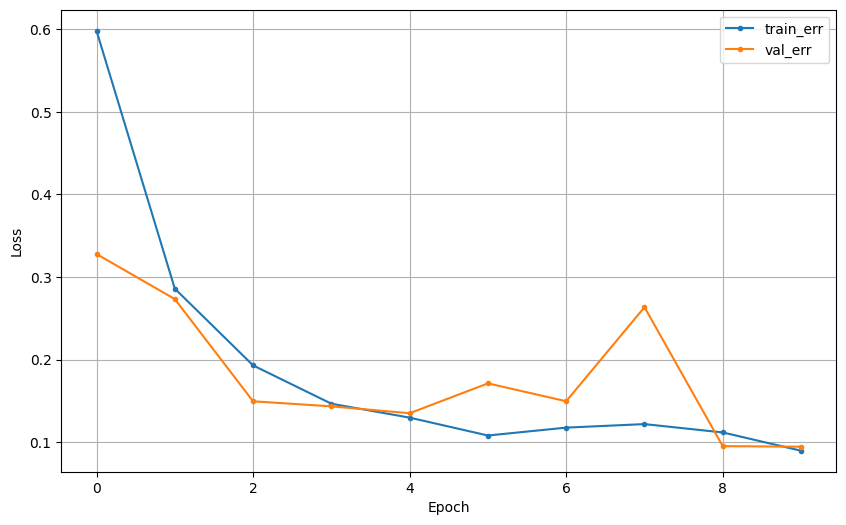

In [31]:
# 학습곡선
dl_history_plot(history.history)

In [32]:
# 예측 및 평가
y_pred = model_static.predict(x_val_static)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_val_le, y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       221
           1       0.94      0.95      0.94       205
           2       0.95      0.95      0.95       221

    accuracy                           0.96       647
   macro avg       0.96      0.96      0.96       647
weighted avg       0.96      0.96      0.96       647



#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [33]:
# (tip) 동적 행동(1)인 데이터 추출
x_train_dynamic = train_data[train_data['is_dynamic'] == 1].drop(['Activity', 'is_dynamic'], axis=1)
y_train_dynamic = train_data[train_data['is_dynamic'] == 1]['Activity']

In [34]:
# (tip) map 활용해서 숫자레이블로 매핑핑
x_train_dynamic, x_val_dynamic, y_train_dynamic, y_val_dynamic = train_test_split(x_train_dynamic,y_train_dynamic, test_size=0.2, random_state=42)

# 정수 인코딩 변환(LabelEncoder)
le = LabelEncoder()
y_train_le = le.fit_transform(y_train_dynamic)
y_val_le = le.transform(y_val_dynamic)

# 기존 레이블 저장
labels = le.classes_

labels

array(['WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'], dtype=object)

In [35]:
y_val_dynamic

,Activity
3663,WALKING
2458,WALKING_DOWNSTAIRS
1895,WALKING_DOWNSTAIRS
913,WALKING
3002,WALKING_DOWNSTAIRS
...,...
1104,WALKING_DOWNSTAIRS
5603,WALKING_DOWNSTAIRS
3590,WALKING_DOWNSTAIRS
2693,WALKING_UPSTAIRS


In [36]:
# 모델 설계
model_dynamic = Sequential()
model_dynamic.add(Dense(128, activation='relu', input_shape=(x_train_dynamic.shape[1],)))
model_dynamic.add(Dense(64, activation='relu'))
model_dynamic.add(Dense(32, activation='relu'))
model_dynamic.add(Dense(len(labels), activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# 컴파일 및 학습
model_dynamic.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

history = model_dynamic.fit(x_train_dynamic, y_train_le, validation_data=(x_val_dynamic, y_val_le), epochs=10, batch_size=32)

Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6834 - loss: 0.7207 - val_accuracy: 0.9434 - val_loss: 0.1734
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9605 - loss: 0.1190 - val_accuracy: 0.9698 - val_loss: 0.0934
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9832 - loss: 0.0519 - val_accuracy: 0.9792 - val_loss: 0.0554
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9920 - loss: 0.0319 - val_accuracy: 0.9849 - val_loss: 0.0449
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9936 - loss: 0.0244 - val_accuracy: 0.9811 - val_loss: 0.0512
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9972 - loss: 0.0113 - val_accuracy: 0.9849 - val_loss: 0.0304
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9868 - val_loss: 0.0348
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9906 - val_loss:

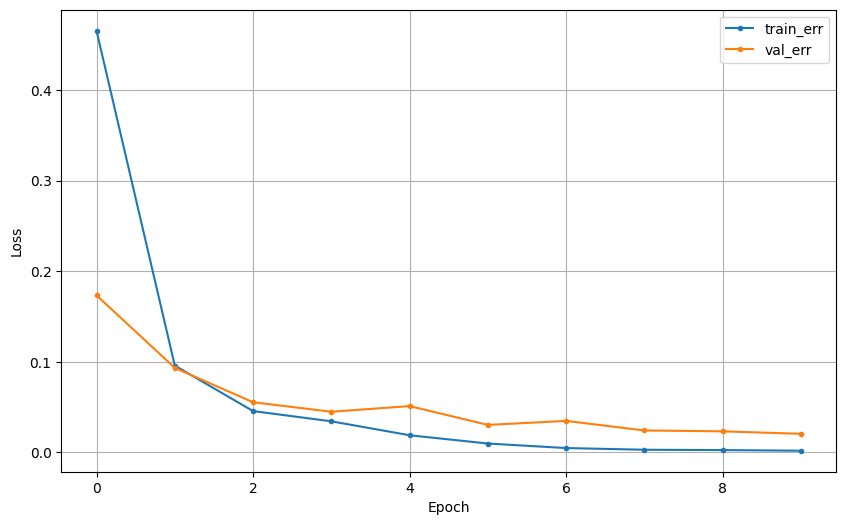

In [38]:
# 학습곡선
dl_history_plot(history.history)

In [39]:
# 예측 및 평가
y_pred = model_dynamic.predict(x_val_dynamic)
print(y_pred)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_val_le, y_pred))

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[[9.9997431e-01 5.4304201e-06 2.0110165e-05]
 [1.4475621e-07 9.9999803e-01 1.7955265e-06]
 [1.1748514e-07 9.9999243e-01 7.4211944e-06]
 ...
 [1.5025487e-04 9.9984193e-01 7.8240810e-06]
 [6.1188621e-06 6.9486021e-05 9.9992442e-01]
 [9.9999988e-01 1.7431283e-07 2.6321366e-08]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       196
           1       0.99      0.99      0.99       163
           2       0.99      0.98      0.99       171

    accuracy                           0.99       530
   macro avg       0.99      0.99      0.99       530
weighted avg       0.99      0.99      0.99       530



In [40]:
x_val_dynamic

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
3663,0.282329,-0.082669,-0.215886,-0.171779,0.205221,-0.269290,-0.251121,0.238956,-0.278701,0.227922,...,0.217328,-0.105099,-0.427633,-0.094409,0.365098,-0.898356,-0.745972,-0.776505,0.251802,0.001695
2458,0.424993,-0.018164,-0.080291,0.320303,-0.008315,-0.330318,0.230900,-0.051119,-0.351123,0.467976,...,-0.018893,-0.521689,-0.859990,-0.836742,0.884123,0.933036,0.832245,-0.929195,0.137666,-0.012967
1895,0.168313,0.005302,-0.115882,0.044940,-0.123877,-0.422232,-0.048705,-0.108322,-0.407436,0.385541,...,0.136245,-0.604388,-0.896338,0.797712,-0.533280,0.945640,0.422562,-0.828379,0.196061,-0.051942
913,0.171943,0.000519,-0.107163,-0.268608,0.157990,-0.398023,-0.355231,0.166648,-0.385021,-0.039729,...,0.058338,-0.261641,-0.609633,0.902990,0.077173,-0.564066,0.075084,-0.762621,0.260963,-0.002681
3002,0.165726,-0.027413,-0.064931,-0.014775,-0.207899,-0.075730,-0.075050,-0.195036,-0.092079,0.365392,...,0.077240,0.008917,-0.418143,0.715334,-0.665739,0.947535,-0.670335,-0.665961,0.222541,0.218649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,0.348171,-0.035688,-0.118575,-0.366546,-0.163731,-0.497131,-0.401304,-0.194466,-0.526353,-0.264101,...,-0.017602,-0.290463,-0.673758,-0.525590,-0.531382,0.902114,0.924653,-0.679879,0.123585,-0.212129
5603,0.231140,-0.019013,-0.047597,0.108498,-0.334933,-0.217935,0.032996,-0.318021,-0.260585,0.341306,...,0.146754,-0.738305,-0.959924,0.414992,-0.713064,-0.931380,-0.404988,-0.804914,0.110685,0.159117
3590,0.361796,-0.024556,-0.102470,0.068293,0.148133,0.113078,0.022299,0.144965,0.100290,0.422230,...,0.361867,-0.389734,-0.767310,-0.737080,0.896907,0.955474,-0.241589,-0.658878,0.203651,0.236259
2693,0.350708,-0.030424,-0.079949,-0.303905,-0.214321,-0.328428,-0.372866,-0.326088,-0.402311,0.068185,...,0.018331,-0.200070,-0.562147,-0.497417,-0.360054,0.645856,-0.862842,-0.569455,0.324222,0.212042


In [41]:
y_val_le

array([0, 1, 1, 0, 1, 1, 2, 1, 0, 2, 1, 1, 1, 0, 0, 2, 0, 2, 2, 0, 1, 0,
       0, 1, 0, 1, 2, 0, 1, 2, 2, 1, 0, 2, 0, 1, 2, 1, 2, 0, 1, 0, 2, 0,
       0, 2, 2, 1, 1, 0, 0, 2, 0, 1, 0, 2, 2, 2, 0, 0, 0, 2, 0, 1, 0, 2,
       2, 1, 1, 2, 1, 2, 1, 0, 2, 2, 1, 0, 2, 1, 2, 1, 0, 0, 2, 0, 0, 2,
       0, 0, 2, 1, 1, 2, 0, 2, 1, 1, 2, 1, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
       1, 0, 2, 1, 0, 0, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1, 2, 0, 2, 0, 2, 2,
       1, 2, 2, 2, 2, 0, 1, 2, 2, 0, 0, 1, 0, 2, 2, 0, 2, 2, 0, 1, 1, 0,
       2, 2, 1, 1, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 2, 0, 1, 2, 0, 1, 1,
       1, 0, 0, 2, 2, 1, 1, 0, 0, 1, 2, 1, 2, 0, 2, 0, 0, 2, 2, 1, 1, 0,
       1, 1, 1, 2, 2, 1, 1, 0, 0, 1, 2, 1, 0, 1, 1, 2, 2, 2, 0, 0, 0, 0,
       1, 2, 0, 0, 2, 2, 0, 1, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1, 2, 0, 1, 2,
       2, 0, 2, 2, 0, 2, 1, 1, 1, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       2, 2, 1, 2, 0, 0, 1, 1, 2, 1, 0, 0, 1, 2, 1, 1, 2, 1, 0, 2, 1, 0,
       0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,

In [42]:
y_pred

array([0, 1, 1, 0, 1, 1, 2, 1, 0, 2, 1, 1, 2, 0, 0, 2, 0, 2, 2, 0, 1, 0,
       0, 1, 0, 1, 2, 0, 1, 2, 2, 1, 0, 2, 0, 1, 2, 1, 2, 0, 1, 0, 2, 0,
       0, 2, 2, 1, 1, 0, 0, 2, 0, 1, 0, 2, 2, 2, 0, 0, 0, 2, 0, 1, 0, 2,
       2, 1, 1, 2, 1, 2, 1, 0, 2, 2, 1, 0, 2, 1, 2, 1, 0, 0, 2, 0, 0, 2,
       0, 0, 2, 1, 1, 2, 0, 2, 1, 1, 2, 1, 2, 2, 2, 1, 0, 0, 2, 2, 0, 1,
       1, 0, 2, 1, 0, 0, 0, 1, 0, 2, 0, 2, 0, 1, 0, 1, 2, 0, 2, 0, 2, 2,
       1, 2, 2, 2, 2, 0, 1, 2, 2, 0, 0, 1, 0, 2, 2, 0, 2, 2, 0, 1, 1, 0,
       2, 0, 1, 1, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 2, 2, 1, 1, 0, 0, 1, 2, 1, 2, 0, 2, 0, 0, 2, 2, 1, 1, 0,
       1, 1, 1, 2, 2, 1, 1, 0, 0, 1, 2, 1, 0, 1, 1, 2, 2, 2, 0, 0, 0, 0,
       1, 2, 0, 0, 2, 2, 0, 1, 1, 1, 1, 2, 0, 0, 2, 0, 2, 1, 2, 0, 1, 2,
       2, 0, 2, 2, 0, 2, 1, 1, 1, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       2, 2, 1, 2, 0, 0, 1, 1, 2, 1, 0, 0, 1, 2, 1, 1, 2, 1, 0, 2, 1, 2,
       0, 2, 0, 2, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,

### (3) (옵션) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [43]:
#(tip) 함수 만들기
# 1. 전처리
# 1-1. 스케일링
# 1-2. 입력값 만들기
#-------------------
# 2. 예측하기
# 2-1. 단계1을 모델로 0,1 구분
# 2-2. 단계 1의 결과로 데이터 나누기
# 2-3. 단계2 모델로 예측
# 2-4. 예측 결과 원래 값으로 변환
# 2-5. 하나로 합쳐보기
#-------------------
# 3. 최종 성능평가 하기

In [44]:
from keras.utils import to_categorical

In [45]:
x_test, y_test = test_data.drop(['Activity', 'is_dynamic'], axis=1)[:50], test_data['Activity'][:50]
x_test

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,0.255432,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.166341,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.468354,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,0.337635,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,-0.594792,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615
5,0.336801,0.010528,-0.057819,-0.435988,-0.126317,0.037931,-0.446406,-0.244650,-0.034606,-0.288437,...,0.157082,0.115015,-0.351891,-0.174328,0.558749,0.664988,0.544573,-0.775712,0.187548,0.149686
6,0.447718,0.207096,-0.117430,-0.843029,-0.101380,-0.553765,-0.849087,-0.049920,-0.552505,-0.710284,...,-0.288501,-0.298895,-0.595825,-0.052553,0.173963,-0.214500,-0.259947,-0.794966,0.233738,-0.024725
7,0.277187,-0.022683,-0.118381,-0.996433,-0.981620,-0.957283,-0.996739,-0.981849,-0.952571,-0.939274,...,0.358568,-0.376028,-0.685160,-0.026671,0.291394,0.036454,-0.293257,-0.911496,0.098167,0.083419
8,0.276296,-0.013342,-0.103463,-0.997334,-0.989866,-0.982723,-0.997907,-0.989204,-0.981990,-0.941808,...,0.440186,-0.737322,-0.941968,0.020122,-0.246491,0.233787,0.568201,-0.897297,0.023359,0.017694
9,0.087902,-0.118993,-0.052787,-0.217817,-0.148752,0.079020,-0.294967,-0.165066,0.137718,0.070103,...,-0.133990,-0.535753,-0.842876,0.313940,0.577018,-0.968008,0.525585,-0.872144,0.186079,0.007999


In [46]:
# (옵션) 위 참고해서 분류모델 파이프라인 만들어보기

def pipeline(test_data):
    # x, y 분할
    x_test, y_test = test_data.drop(['Activity', 'is_dynamic'], axis=1), test_data['Activity']
    final_pred = []
    static_le = ['LAYING', 'SITTING', 'STANDING']
    dynamic_le = ['WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']
    for x in x_test.values:
        x = x.reshape(1, -1)  # <-- 반드시 reshape 해줘야 함 (1, feature 수)
        sd_pred = model_sd_hid.predict(x)
        sd_pred = np.where(sd_pred > 0.5, 1, 0)

        if sd_pred[0] == 1:
            dynamic_pred = model_dynamic.predict(x)
            y_pred = np.argmax(dynamic_pred, axis=1)
            final_pred.append(dynamic_le[y_pred[0]])
        else:
            static_pred = model_static.predict(x)
            y_pred = np.argmax(static_pred, axis=1)
            final_pred.append(static_le[y_pred[0]])
    return final_pred, y_test


#### 2) test 셋으로 예측하고 평가하기

In [47]:
# test 셋의 구조 한번 확인해보고 성능평가 해보기

In [ ]:
final_pred, y_test = pipeline(test_data)
final_pred = pd.Series(final_pred)
print(classification_report(y_test, final_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [ ]:
my_series = pd.Series(final_pred)

In [ ]:
y_test

,Activity
0,SITTING
1,STANDING
2,WALKING
3,SITTING
4,STANDING
5,WALKING
6,STANDING
7,STANDING
8,SITTING
9,WALKING_UPSTAIRS
